In [1]:
import models.channel_flow as chan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
torch.random.manual_seed(123)

In [30]:
dns_retau180 = pd.read_csv('data/LM_Channel_Retau180.txt', delimiter=' ')

In [63]:
numerical_u = np.load('data/mixing_length_numerical_Retau180.npy')

## $Re_{tau} = 180$

In [31]:
hypers = chan.get_hyperparams(ymin=-1, ymax=1, num_epochs=200000, lr=0.0001, 
                              num_layers=4, num_units=40, batch_size=2000)

In [32]:
hypers['nu']=0.005555555555
delta = (hypers['ymax']-hypers['ymin'])/2
reynolds_stress = chan.get_mixing_len_model(hypers['k'], delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
retau=chan.calc_retau(delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Training at Retau={}'.format(retau))

Training at Retau=180.000000018


In [33]:
half_u180,  half_y180 = chan.convert_dns(delta, hypers, dns_retau180)

In [34]:
pdenn180 = chan.Chanflow(num_units=hypers['num_units'], num_layers=hypers['num_layers'])
losses180 = pdenn180.train(hypers['ymin'], hypers['ymax'],
                                   reynolds_stress,
                                   nu=hypers['nu'],
                                   dp_dx=hypers['dp_dx'],
                                   rho=hypers['rho'],
                                   batch_size=hypers['batch_size'],
                                   epochs=hypers['num_epochs'],
                                   lr=hypers['lr'],
                                   C=1)

100%|██████████| 200000/200000 [2:50:06<00:00, 19.60it/s, loss=0.02]  


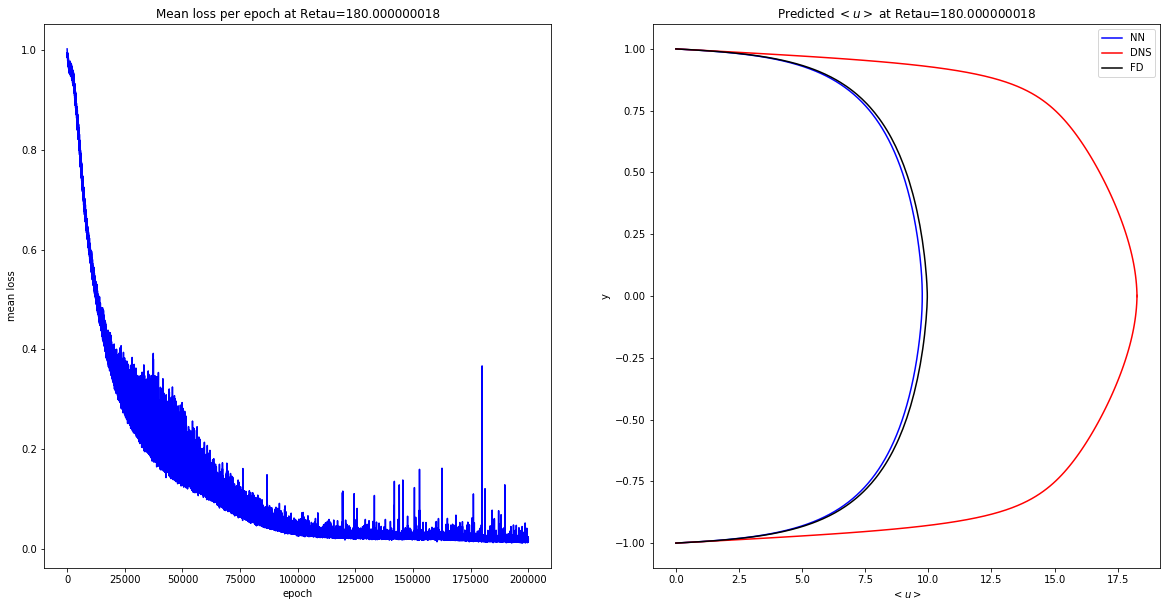

In [69]:
# 2K pts, analytical bcs, 2 hidden, 40 units, 0.0001 LR
fig, ax = plt.subplots(1, 2, figsize=(20,10))
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
chan.plot_dns(ax[1], half_u180, half_y180, delta)
ax[1].plot(numerical_u, np.linspace(-1,1,1000), label='FD', color='black')
ax[1].legend()
plt.show()

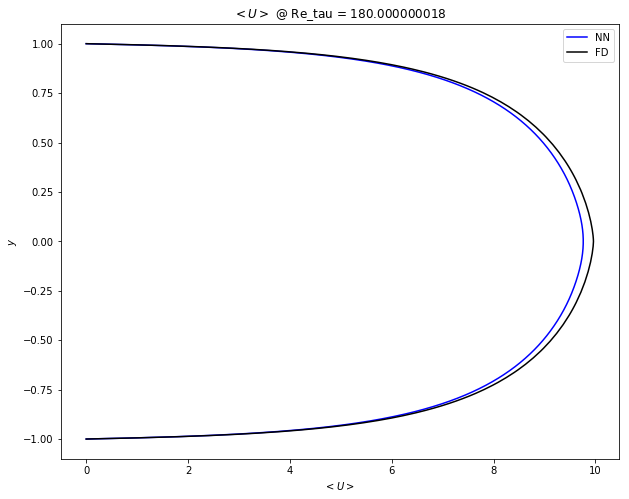

In [89]:
# 2K pts, analytical bcs, 2 hidden, 40 units, 0.0001 LR
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# chan.make_plots(ax, losses180, pdenn180, hypers, retau)
# chan.plot_dns(ax[1], half_u180, half_y180, delta)
saved_preds=np.load('data/preds_retau180_200k_epochs_2k_batchsize.npy')
ax.plot(saved_preds, np.linspace(-1,1,1000), label='NN', color='blue')
ax.plot(numerical_u, np.linspace(-1,1,1000), label='FD', color='black')
ax.set_title('$<U>$ @ Re_tau = {}'.format(retau))
ax.set_xlabel('$<U>$')
ax.set_ylabel('$y$')
ax.legend()
plt.show()

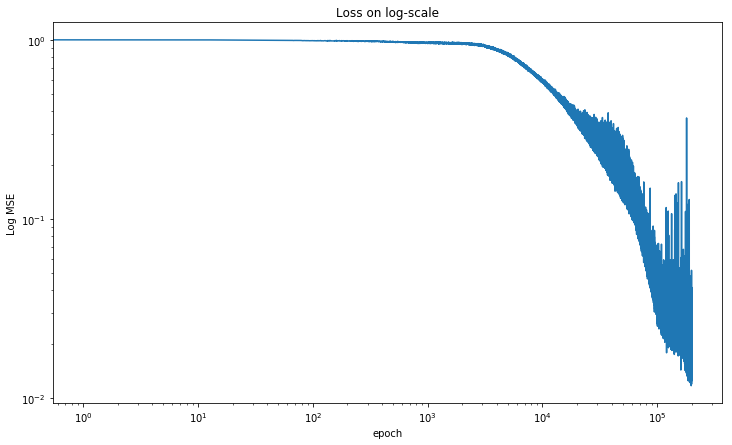

In [94]:
plt.figure(figsize=(12,7))
plt.loglog(np.arange(len(losses180)), losses180)
plt.title('Loss on log-scale')
plt.xlabel('epoch')
plt.ylabel('Log MSE')
plt.show()

In [77]:
def loss_vs_distance(ymin, ymax):
    y = torch.tensor(torch.linspace(ymin,ymax,1000).reshape(-1,1), requires_grad=True)
    u_bar = pdenn180.predict(y)
    axial_eqn = pdenn180.compute_diffeq(u_bar, y, reynolds_stress, hypers['nu'], hypers['rho'], hypers['dp_dx'])

    plt.figure(figsize=(12,7))
#     plt.plot(y.detach().numpy(), np.abs(axial_eqn.detach().numpy()), 'o', markersize=2, lw=0.5, label='abs')
    plt.plot(y.detach().numpy(), np.power(axial_eqn.detach().numpy(), 2), 'o', markersize=2, lw=0.5, label='square')
    plt.title('Loss as a function of distance on ({}, {})'.format(ymin, ymax))
    plt.ylabel('Loss (f^2 or |f|)')
    plt.xlabel('position (y)')
    plt.legend()
    plt.show()

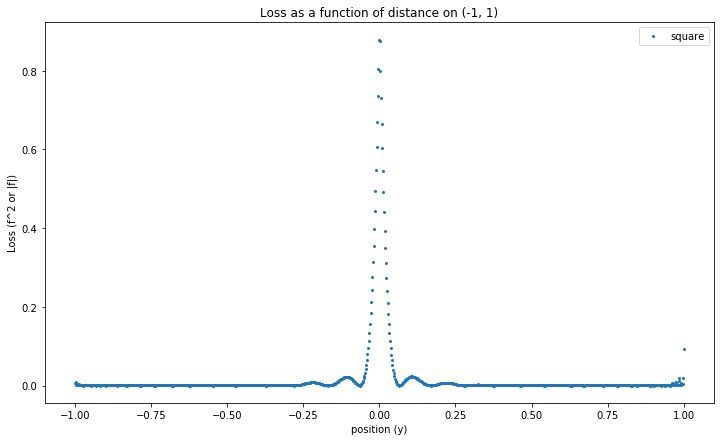

In [78]:
loss_vs_distance(-1,1)

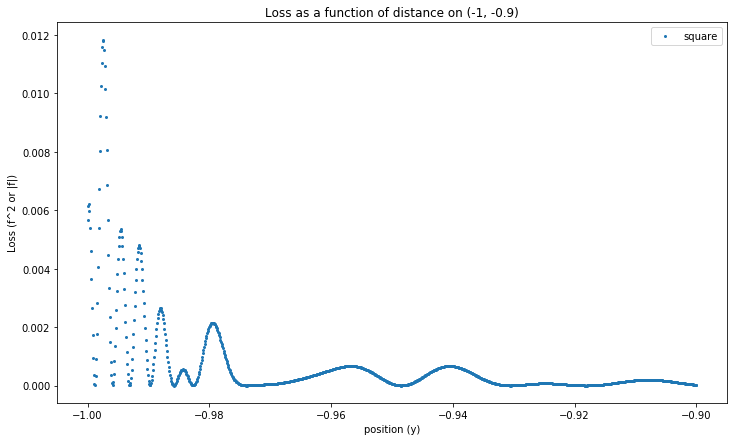

In [79]:
loss_vs_distance(-1,-0.9)

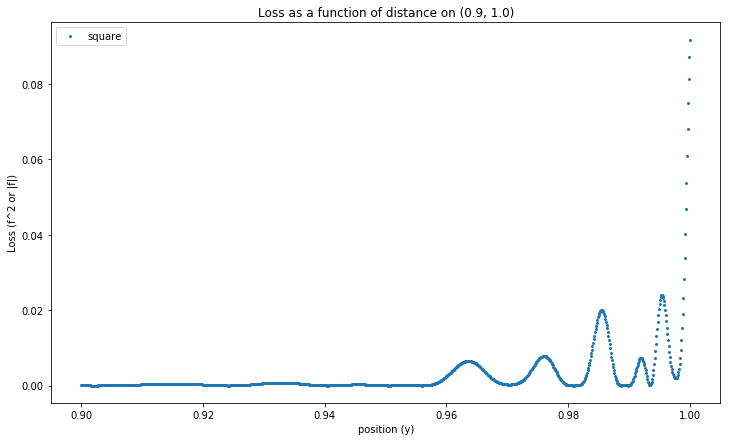

In [90]:
loss_vs_distance(0.9, 1.)

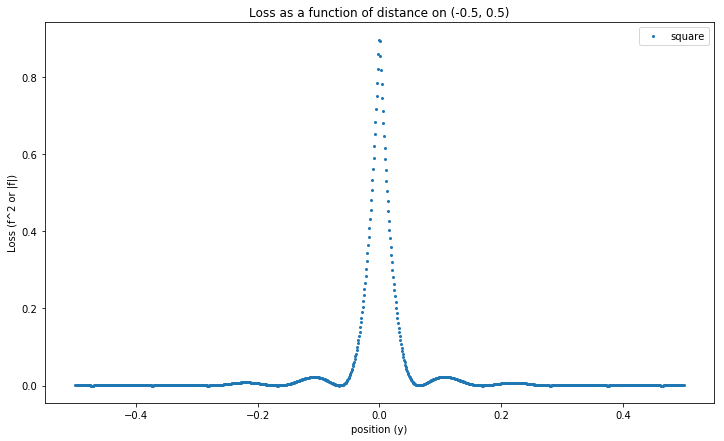

In [80]:
loss_vs_distance(-.5,.5)

## Stopped after 20K epoch

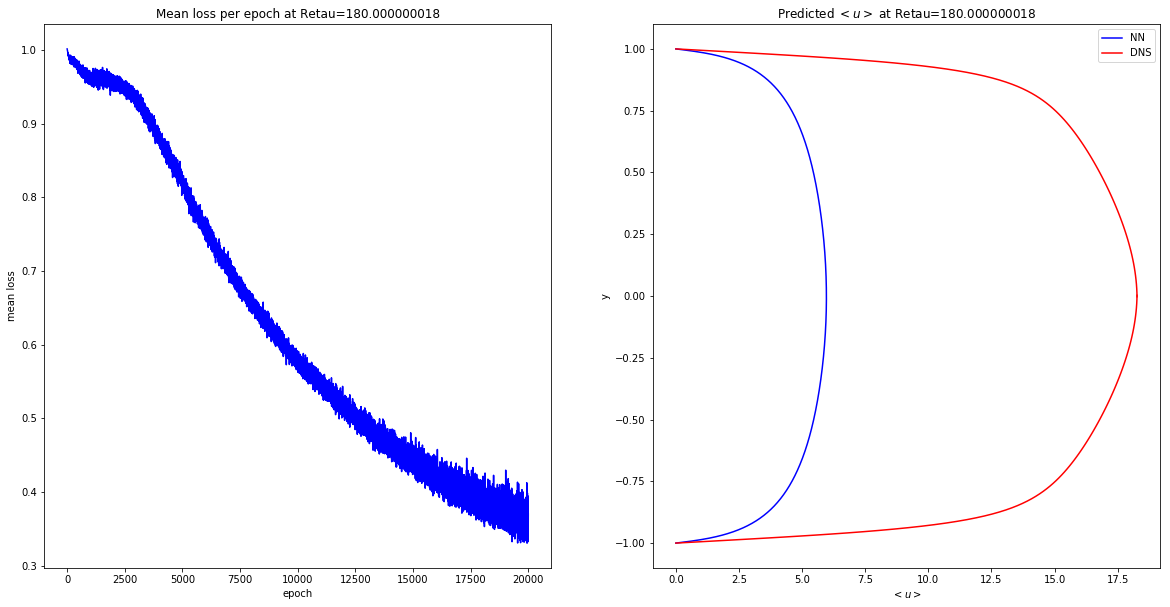

In [18]:
# 2K pts, analytical bcs, 2 hidden, 40 units, 0.0001 LR
fig, ax = plt.subplots(1, 2, figsize=(20,10))
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
chan.plot_dns(ax[1], half_u180, half_y180, delta)

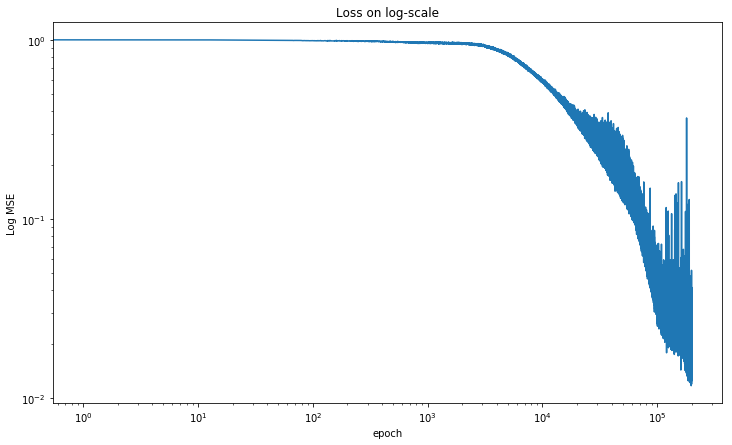

In [92]:
plt.figure(figsize=(12,7))
plt.loglog(np.arange(len(losses180)), losses180)
plt.title('Loss on log-scale')
plt.xlabel('epoch')
plt.ylabel('Log MSE')
plt.show()

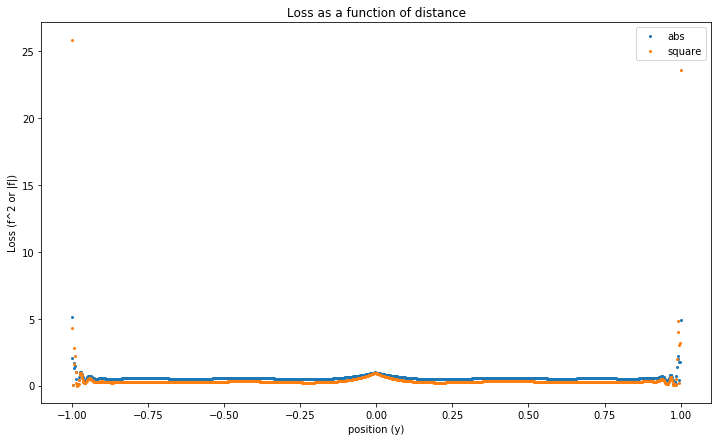

In [25]:
y = torch.tensor(torch.linspace(-1,1,1000).reshape(-1,1), requires_grad=True)
u_bar = pdenn180.predict(y)
axial_eqn = pdenn180.compute_diffeq(u_bar, y, reynolds_stress, hypers['nu'], hypers['rho'], hypers['dp_dx'])

plt.figure(figsize=(12,7))
plt.plot(y.detach().numpy(), np.abs(axial_eqn.detach().numpy()), 'o', markersize=2, lw=0.5, label='abs')
plt.plot(y.detach().numpy(), np.power(axial_eqn.detach().numpy(), 2), 'o', markersize=2, lw=0.5, label='square')
plt.title('Loss as a function of distance')
plt.ylabel('Loss (f^2 or |f|)')
plt.xlabel('position (y)')
plt.legend()
plt.show()

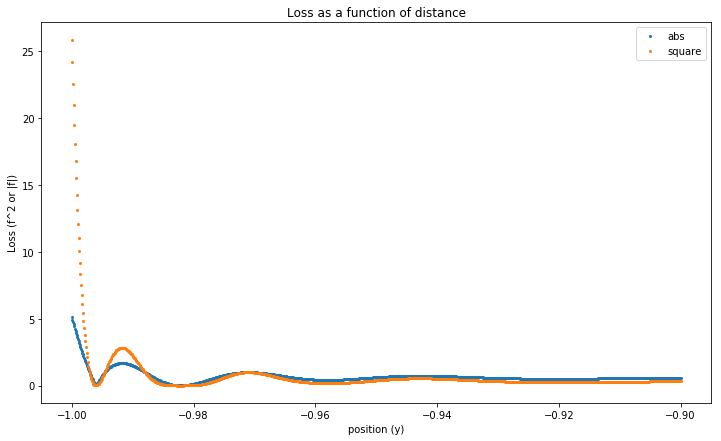

In [24]:
y = torch.tensor(torch.linspace(-1,-0.9,1000).reshape(-1,1), requires_grad=True)
u_bar = pdenn180.predict(y)
axial_eqn = pdenn180.compute_diffeq(u_bar, y, reynolds_stress, hypers['nu'], hypers['rho'], hypers['dp_dx'])

plt.figure(figsize=(12,7))
plt.plot(y.detach().numpy(), np.abs(axial_eqn.detach().numpy()), 'o', markersize=2, lw=0.5, label='abs')
plt.plot(y.detach().numpy(), np.power(axial_eqn.detach().numpy(), 2), 'o', markersize=2, lw=0.5, label='square')
plt.title('Loss as a function of distance')
plt.ylabel('Loss (f^2 or |f|)')
plt.xlabel('position (y)')
plt.legend()
plt.show()

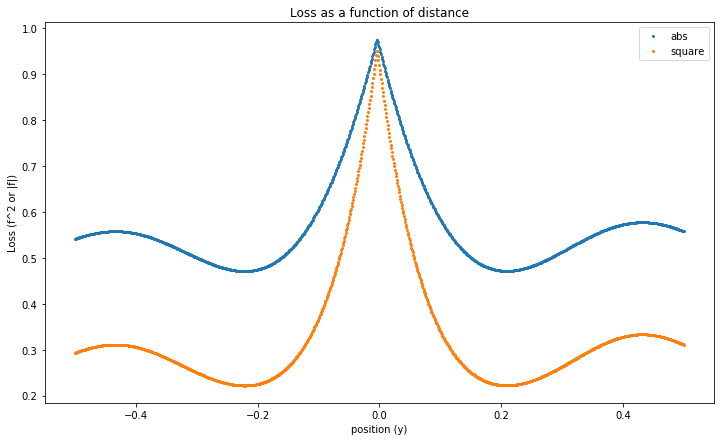

In [22]:
y = torch.tensor(torch.linspace(-.5,.5,1000).reshape(-1,1), requires_grad=True)
u_bar = pdenn180.predict(y)
axial_eqn = pdenn180.compute_diffeq(u_bar, y, reynolds_stress, hypers['nu'], hypers['rho'], hypers['dp_dx'])

plt.figure(figsize=(12,7))
plt.plot(y.detach().numpy(), np.abs(axial_eqn.detach().numpy()), 'o', markersize=2, lw=0.5, label='abs')
plt.plot(y.detach().numpy(), np.power(axial_eqn.detach().numpy(), 2), 'o', markersize=2, lw=0.5, label='square')
plt.title('Loss as a function of distance')
plt.ylabel('Loss (f^2 or |f|)')
plt.xlabel('position (y)')
plt.legend()
plt.show()

## LR too big

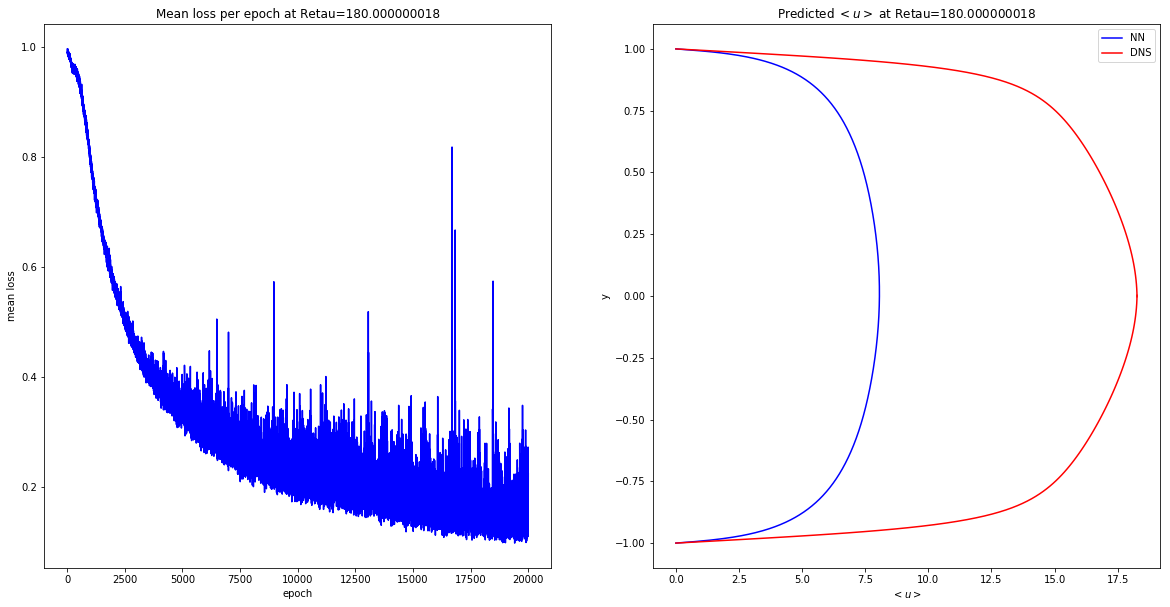

In [7]:
# 2K pts, analytical bcs, 2 hidden, 40 units, 0.0005 LR
fig, ax = plt.subplots(1, 2, figsize=(20,10))
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
chan.plot_dns(ax[1], half_u180, half_y180, delta)

## LR way too big

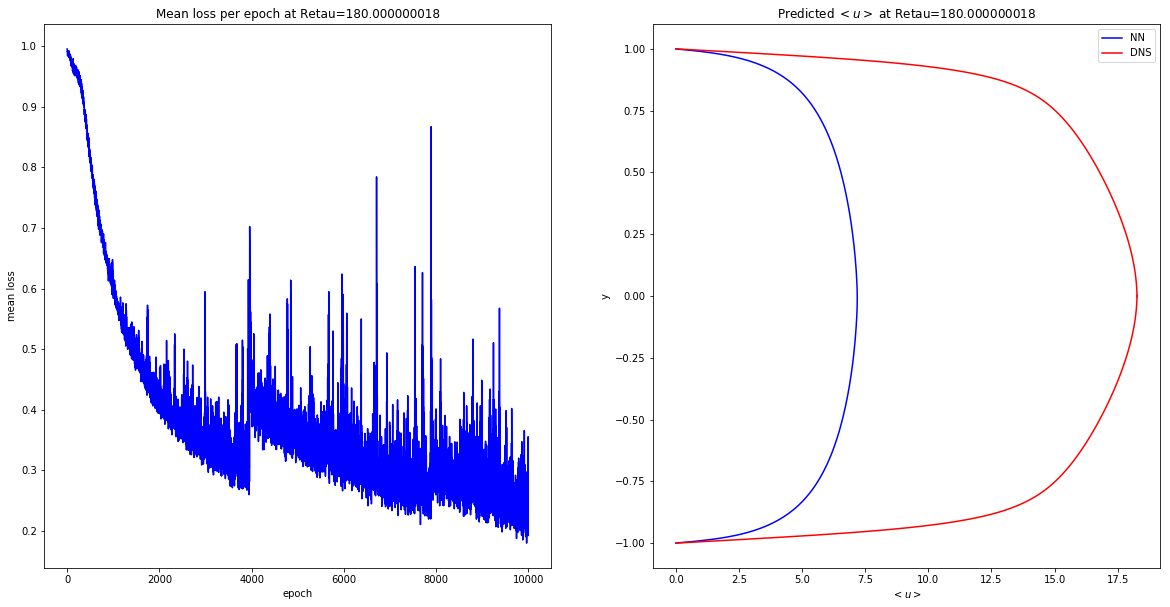

In [9]:
# 2K pts, analytical bcs, 2 hidden, 40 units, 0.001 LR
fig, ax = plt.subplots(1, 2, figsize=(20,10))
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
chan.plot_dns(ax[1], half_u180, half_y180, delta)

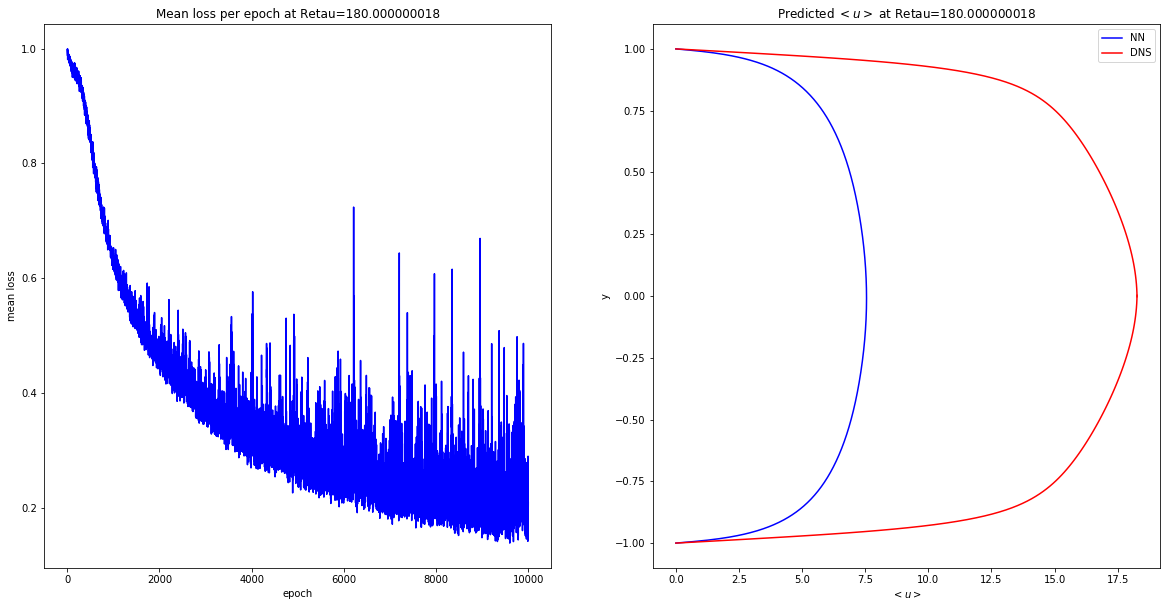

In [16]:
# 1K pts, analytical bcs, 2 hidden, 40 units, 0.001 LR
fig, ax = plt.subplots(1, 2, figsize=(20,10))
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
chan.plot_dns(ax[1], half_u180, half_y180, delta)